---
# **IMPORT**
---

In [34]:
import os
import io
from embeding import *
from vector_store import *
import csv
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!docker run -p 6333:6333 qdrant/qdrant

docker: Error response from daemon: driver failed programming external connectivity on endpoint goofy_mclaren (34973439020fad70cca4d4fa55b5e1bd1341edd35bca7d8d1351f5343ac7156c): Bind for 0.0.0.0:6333 failed: port is already allocated.


In [15]:
qdrant_url = "http://localhost:6333"
token = ""

vector_space = QdrantVectorSpace(
    qdrant_url=qdrant_url,
    token=token,
    collection_name="run",
    snapshot=True
)
vector_space.load_snapshot("../result/collection/image.snapshot")

Snapshot uploaded successfully.
Response: {'result': True, 'status': 'ok', 'time': 13.295469203}


In [4]:
image_database = ImageDatabaseSQL("/mnt/d/Data/AI/image.sqlite", "image")
image_database.connect()

In [5]:
model = JinaTextEmbeding('../weights/jina-clip-v1')

---
# **SETTING BEFORE RUNNING**
---

In [26]:
folder_sum = "../run/test"
folder_input = os.path.join(folder_sum, "english")
folder_output = os.path.join(folder_sum, "result")
folder_check = os.path.join(folder_sum, "check")

os.makedirs(folder_output, exist_ok=True)
os.makedirs(folder_check, exist_ok=True)

troll_video = ["L09_V009", "L06_V003"]

---
# **RUNNING**
---

In [39]:
data = []
file_names = os.listdir(folder_input)
for each in file_names:
    file_path = os.path.join(folder_input, each)
    with open(file_path, 'r') as f:
        data.append(f.read())

In [40]:
result = model.inference(data, norm_embeds=True)

In [52]:
for each_embedding, each_file in zip(result[0], file_names):
    answer = vector_space.query_by_text(each_embedding, top_k=100)

    # Result
    file_output = os.path.join(folder_output, each_file)
    file_output = file_output.replace(".txt", ".csv")

    # Check
    file_check = os.path.join(folder_check, each_file)
    file_check = file_check.replace(".txt", ".csv")

    with open(file_output, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        for scored_point in answer:
            video_id = scored_point.payload.get('video_id', '')
            frame_id = scored_point.payload.get('frame_id', '')

            if video_id in troll_video:
                frame_id = str(int(frame_id) * 25 / 30)
                print("Hi")
            csvwriter.writerow([video_id, frame_id])

    with open(file_check, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Video ID', 'Our Frame ID', 'BTC Frame id', 'Time'])
        
        for scored_point in answer:
            video_id = scored_point.payload.get('video_id', '')
            frame_id = scored_point.payload.get('frame_id', '')

            index_time = int(frame_id) / 25
            minute = index_time // 60
            second = index_time % 60
            index_time = f"{int(minute)}:{second:.2f}"

            btc_frame_id = frame_id
            if video_id in troll_video:
                btc_frame_id = int(frame_id) * 25 / 30
                
            csvwriter.writerow([video_id, frame_id, btc_frame_id, index_time])

Hi
Hi
Hi
Hi
Hi
Hi


---
# **CHECK IMAGE**
---

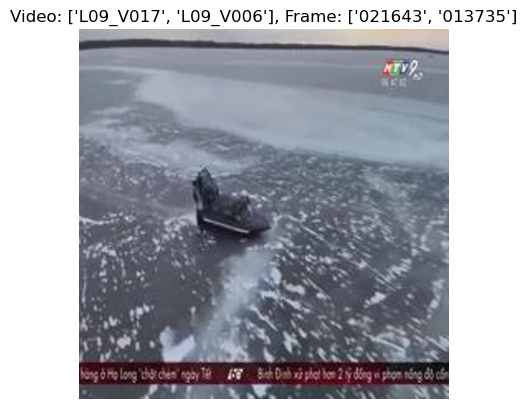

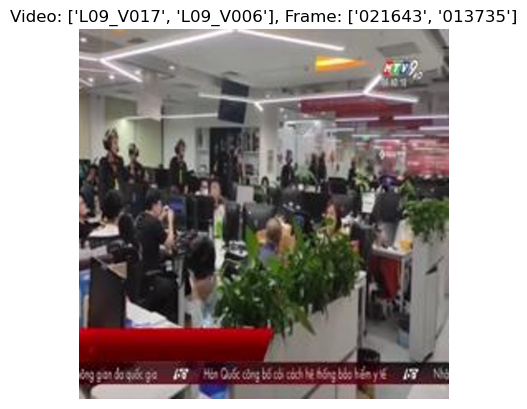

In [38]:
def get_image(video_id, frame_id):
    query = "SELECT image FROM image WHERE video_id = ? AND keyframe_id = ?"
    cursor = image_database.get_cursor()

    result = cursor.execute(query, (video_id, frame_id))
    result = result.fetchone()

    return Image.open(io.BytesIO(result[0])).resize((640, 640))

for each_video, each_frame in zip(video_id, frame_id):
    a = get_image(each_video, each_frame)
    plt.imshow(a)
    plt.title(f"Video: {video_id}, Frame: {frame_id}")
    plt.axis('off')
    plt.show()

---
# **ADD RESULT FOR QA**
---

### **- Add**

In [31]:
input_file = "/home/alex/AI Challenge/temp_AI_flow/run/test/result/query-5-qa.csv"
content = "HI"

df = pd.read_csv(input_file, header=None)
df[""] = content
df.to_csv(input_file, index=False, header=None)

### **- Remove**

In [32]:
input_file = "/home/alex/AI Challenge/temp_AI_flow/run/test/result/query-5-qa.csv"

df = pd.read_csv(input_file, header=None)
df = df.iloc[:, :-1]
df.to_csv(input_file, index=False, header=None)